# Gridding the AHCCD Dataset

### Importing

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc
import dask
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import Rbf
from shapely.geometry import Point
import cartopy.io.shapereader as shpreader
from scipy.spatial import cKDTree
from sklearn.model_selection import train_test_split

### Interpolation and RMSE Calculation

Interpolated data saved to /Users/maxMax/Desktop/Jupyter Notebooks/mean_temp_interpolated/Mean Temperature_interpolated_2000.nc


/opt/anaconda3/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:498: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  re

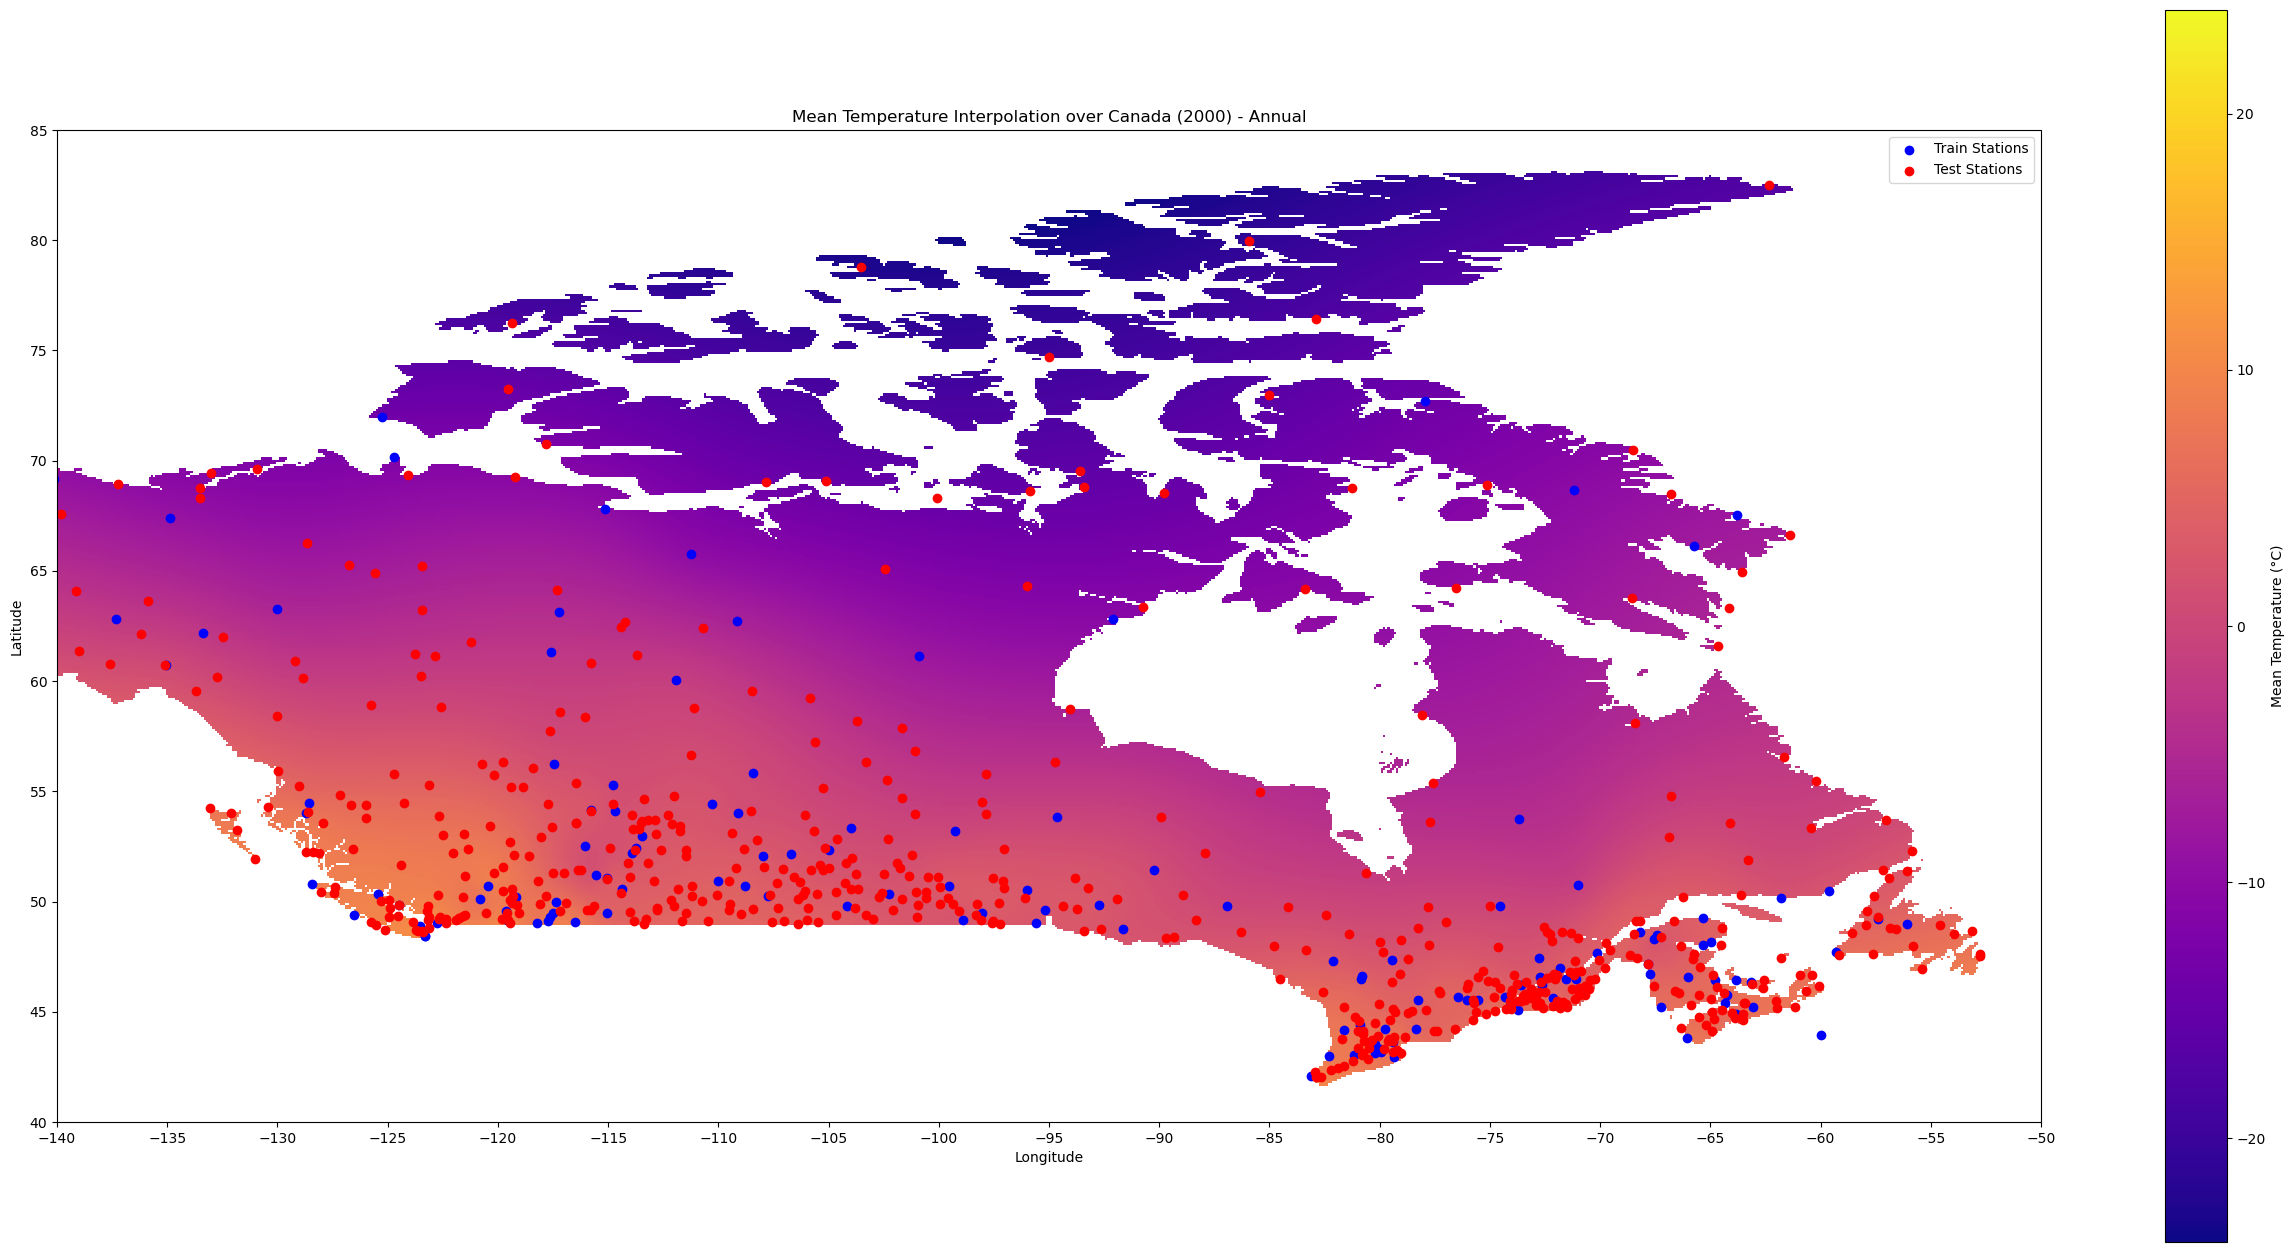

RMSE for 2000: 1.21 °C
Interpolated data saved to /Users/maxMax/Desktop/Jupyter Notebooks/mean_temp_interpolated/Mean Temperature_interpolated_2000.nc


/opt/anaconda3/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:498: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().get_tightbbox(renderer, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  re

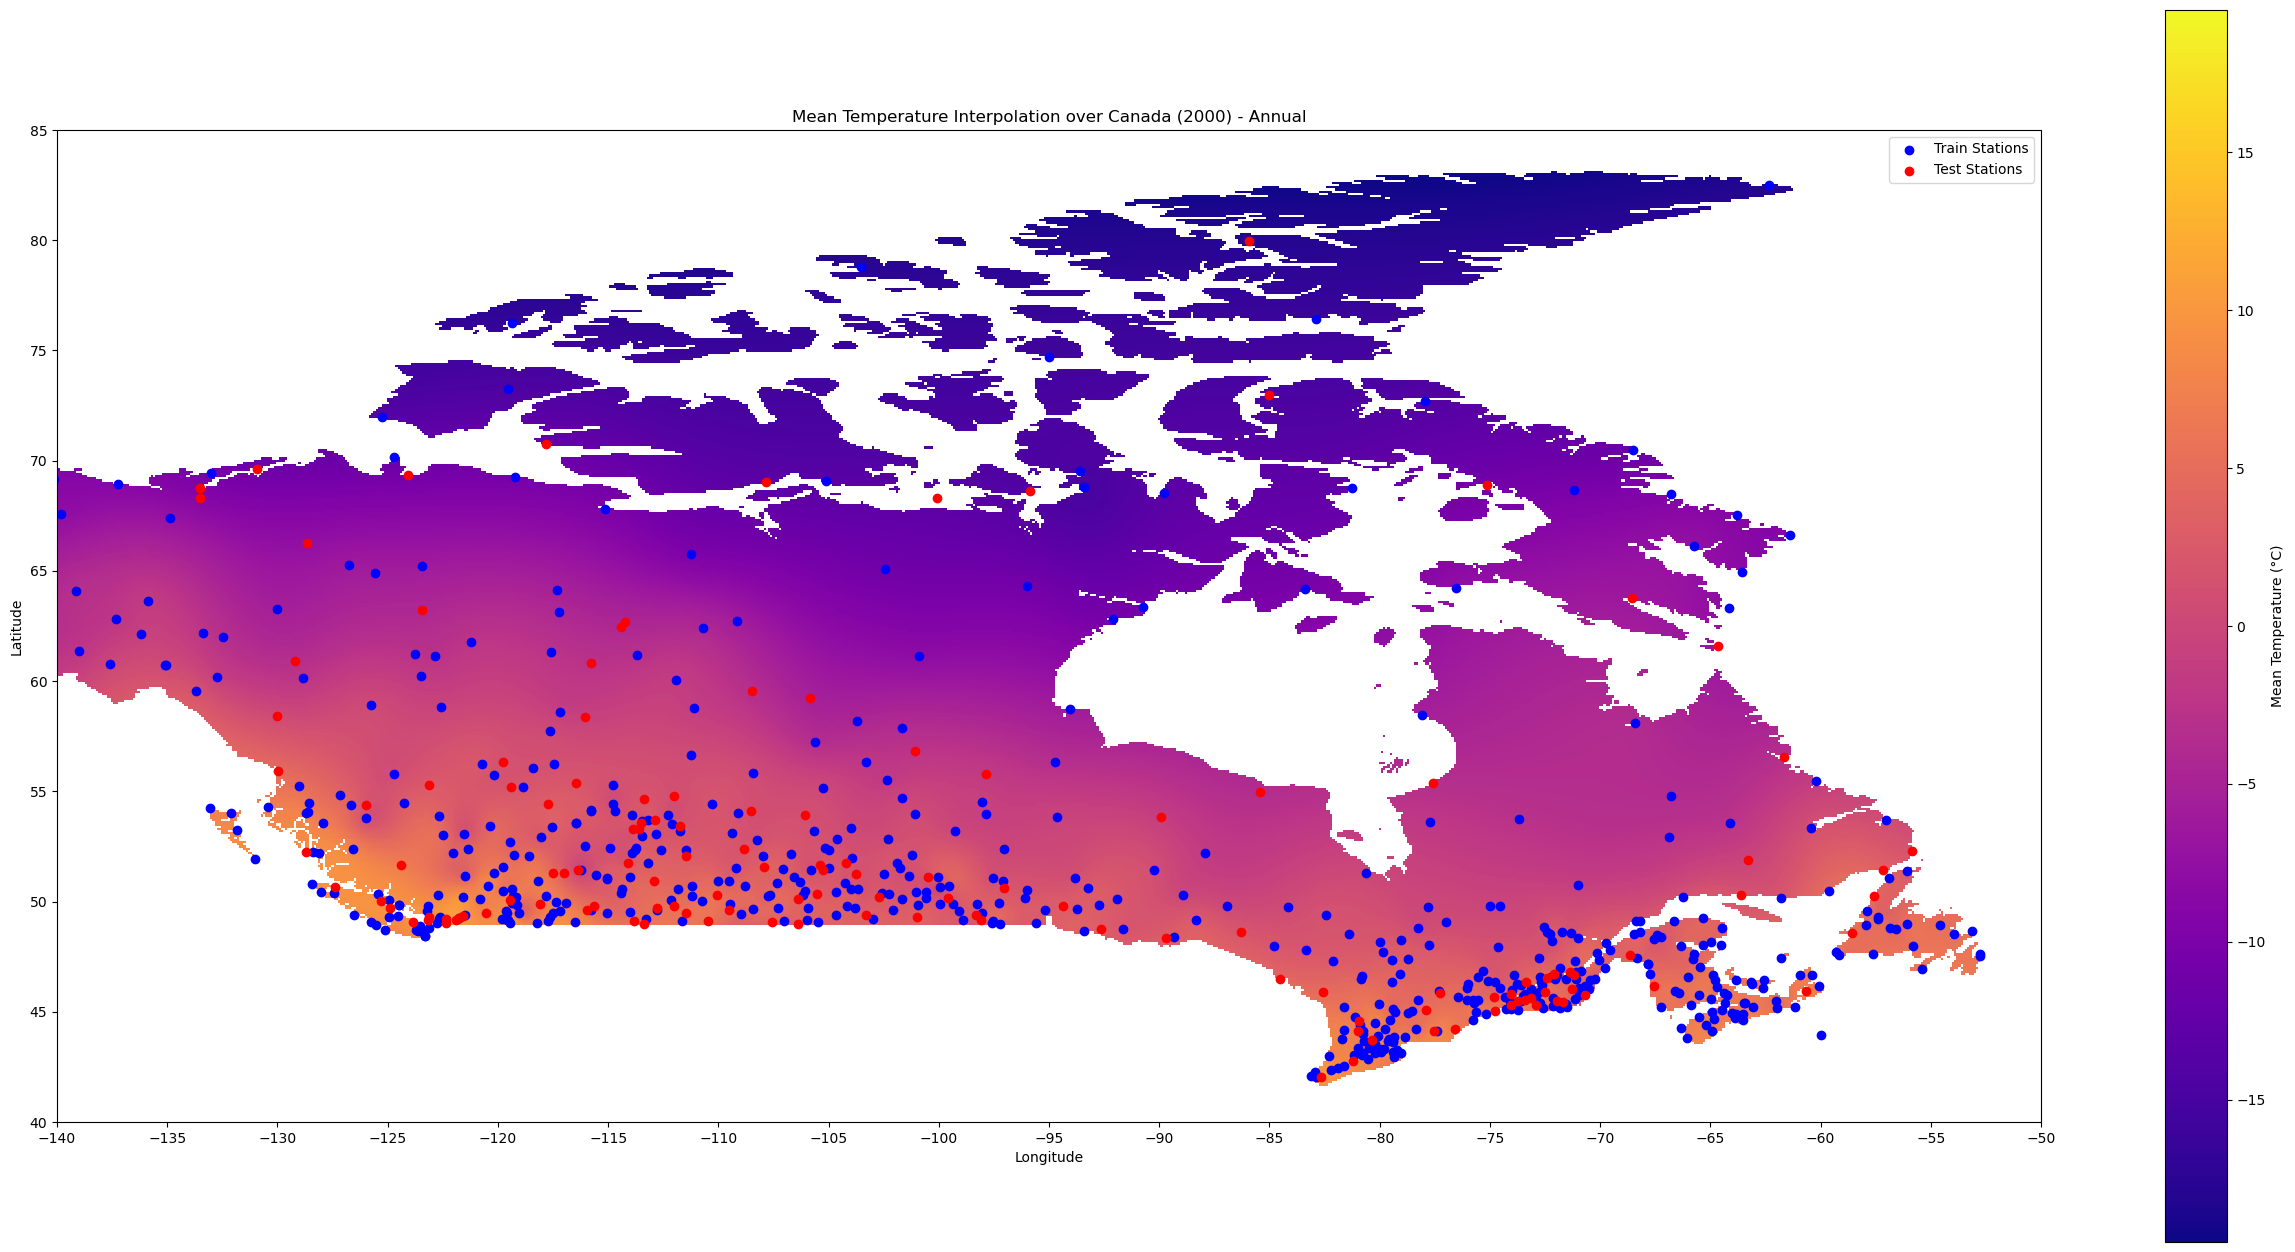

RMSE for 2000: 0.94 °C


In [84]:
ecws_data = pd.read_csv('AHCCD.csv')

def calculate_rmse(grid_lon, grid_lat, interpolated_grid, verification_stations):
    """Calculate RMSE using grid data and verification stations."""
    grid_points = np.array([(lon, lat) for lon, lat in zip(grid_lon.flatten(), grid_lat.flatten())])
    tree = cKDTree(grid_points)#create kdtree for grid points
    verification_coords = np.array(list(zip(verification_stations['Longitude'], verification_stations['Latitude'])))#coords of stations
    distances, indices = tree.query(verification_coords)#find nearest grid cell for each station
    
    grid_values_at_stations = interpolated_grid.flatten()[indices]#extract interpolated values at verification station locations
    station_values = verification_stations['Annual'].values#get actual values from verification stations
    
    rmse = np.sqrt(np.mean((grid_values_at_stations - station_values) ** 2))#calculate rmse
    return rmse

def plot_interpolated_data(value_type, year, columns, interpolation_stations, verification_stations):
    data_subset = interpolation_stations.drop_duplicates(subset=['Longitude', 'Latitude'])#filter data for interpolation stations
    
    ecws_lon = data_subset['Longitude'].values
    ecws_lat = data_subset['Latitude'].values
    mean_values = data_subset[columns].mean(axis=1).values

    valid_indices = ~np.isnan(mean_values)#removing nan values
    ecws_lon = ecws_lon[valid_indices]
    ecws_lat = ecws_lat[valid_indices]
    mean_values = mean_values[valid_indices]
    
    lat_min, lat_max = 40, 85 #defining grid boundaries
    lon_min, lon_max = -140, -50
    lat_res, lon_res = 0.1, 0.1 #defining resolution

    latitudes = np.arange(lat_min, lat_max, lat_res) #creating grid
    longitudes = np.arange(lon_min, lon_max, lon_res)
    grid_lon, grid_lat = np.meshgrid(longitudes, latitudes)

    rbf_interpolator = Rbf(ecws_lon, ecws_lat, mean_values, function='thin_plate') #interpolating data
    interpolated_grid = rbf_interpolator(grid_lon, grid_lat)
    
    shape_reader = shpreader.natural_earth(resolution='50m', category='cultural', name='admin_0_countries') #masking data outside canada boundaries
    canada_shape = [record.geometry for record in shpreader.Reader(shape_reader).records() if record.attributes['NAME'] == 'Canada'][0]
    mask = np.zeros(interpolated_grid.shape, dtype=bool)
    for i in range(grid_lon.shape[0]):
        for j in range(grid_lon.shape[1]):
            point = Point(grid_lon[i, j], grid_lat[i, j])
            if not canada_shape.contains(point):
                mask[i, j] = True

    interpolated_grid = np.ma.array(interpolated_grid, mask=mask)

    data_da = xr.DataArray(#save interpolated data as xarray
        interpolated_grid,
        dims=("latitude", "longitude"),
        coords={
            "latitude": latitudes,
            "longitude": longitudes,
            "year": year
        },
        name=f"{value_type}_interpolated"
    )
    data_da.attrs["description"] = f"{value_type} Interpolation over Canada (RBF Multiquadratic)"

    output_folder = "/Users/maxMax/Desktop/Jupyter Notebooks/mean_temp_interpolated" #save to netCDF
    os.makedirs(output_folder, exist_ok=True)
    output_file = os.path.join(output_folder, f"{value_type}_interpolated_{year}.nc")
    data_da.to_netcdf(output_file, mode="w")
    print(f"Interpolated data saved to {output_file}")

    fig, ax = plt.subplots(figsize=(32, 16), subplot_kw={'projection': ccrs.PlateCarree()})#plotting
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    data_da.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='plasma', cbar_kwargs={'label': f'{value_type} (°C)'})
    ax.set_xticks(np.arange(lon_min, lon_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat_min, lat_max + 1, 5), crs=ccrs.PlateCarree())
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"{value_type} Interpolation over Canada ({year}) - {', '.join(columns)}")

    ax.scatter(#plotting train stations
        interpolation_stations['Longitude'], interpolation_stations['Latitude'],
        color='blue', label='Train Stations', transform=ccrs.PlateCarree()
    )

    ax.scatter(#plotting test stations
        verification_stations['Longitude'], verification_stations['Latitude'],
        color='red', label='Test Stations', transform=ccrs.PlateCarree()
    )

    ax.legend()
    plt.show()
    
    return grid_lon, grid_lat, interpolated_grid

for i in range(2000, 2001):
    year_data = ecws_data[(ecws_data['Value Type'] == 'Mean Temperature') & (ecws_data['Year'] == i)] #split data into interpolatioon and verification (test and train)
    verification_stations, interpolation_stations = train_test_split(
        year_data,
        test_size=0.2,
        random_state=42
    )

    grid_lon, grid_lat, interpolated_grid = plot_interpolated_data(#interpolate grid data and plot
        'Mean Temperature', i, ['Annual'], interpolation_stations, verification_stations
    )

    rmse = calculate_rmse(grid_lon, grid_lat, interpolated_grid, verification_stations) #rmse
    print(f"RMSE for {i}: {rmse:.2f} °C")
    
for i in range(2000, 2001):
    year_data = ecws_data[(ecws_data['Value Type'] == 'Mean Temperature') & (ecws_data['Year'] == i)]
    verification_stations, interpolation_stations = train_test_split(
        year_data,
        test_size=0.8,
        random_state=42
    )

    grid_lon, grid_lat, interpolated_grid = plot_interpolated_data(
        'Mean Temperature', i, ['Annual'], interpolation_stations, verification_stations
    )

    rmse = calculate_rmse(grid_lon, grid_lat, interpolated_grid, verification_stations)
    print(f"RMSE for {i}: {rmse:.2f} °C")


#### Extra

In [3]:
data = xr.open_mfdataset(r"/Users/maxMax/Desktop/Jupyter Notebooks/mean_temp_interpolated/Mean Temperature_interpolated_2002.nc", parallel=False)

#Opening all the netCDF files in a directory and merging them into one variable - must use /*.cd after folder name to extract all netCDF files in folder.
data_temp = xr.open_mfdataset(r"/Users/maxMax/Desktop/Jupyter Notebooks/mean_temp_interpolated/*.nc", combine='nested', engine="netcdf4", concat_dim="year", parallel=False) #Always set parallel to False when using open_mfdataset. There is a bug in the package.

In [4]:
print(data_temp)

<xarray.Dataset> Size: 975kB
Dimensions:                        (year: 60, latitude: 39, longitude: 52)
Coordinates:
  * latitude                       (latitude) float64 312B 40.0 40.6 ... 62.8
  * longitude                      (longitude) float64 416B -81.0 ... -50.4
  * year                           (year) int64 480B 1950 1951 ... 2008 2009
Data variables:
    Mean Temperature_interpolated  (year, latitude, longitude) float64 973kB dask.array<chunksize=(1, 39, 52), meta=np.ndarray>


In [5]:
var_name = list(data_temp.data_vars.keys())[0]  # Get the first variable name
values = data_temp[var_name].values
print(f"Accessing variable: {var_name}")


Accessing variable: Mean Temperature_interpolated


### Interpolated Time Series of Grid Cell's Mean

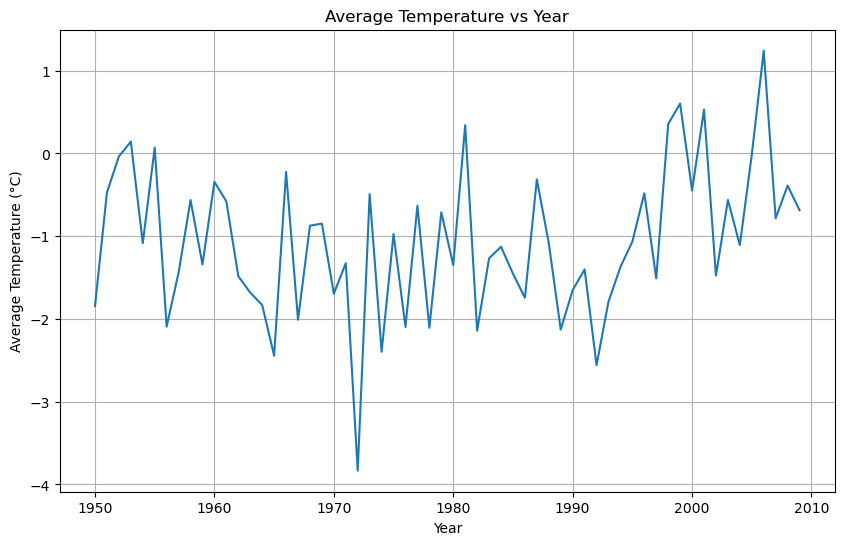

In [6]:
average_temp_per_year = data_temp["Mean Temperature_interpolated"].mean(dim=["latitude", "longitude"])#spatial average for each year
average_temp_df = average_temp_per_year.to_dataframe(name="Average Temperature").reset_index()

plt.figure(figsize=(10, 6))
plt.plot(average_temp_df["year"], average_temp_df["Average Temperature"], linestyle="-")
plt.title("Average Temperature vs Year")
plt.xlabel("Year")
plt.ylabel("Average Temperature (°C)")
plt.grid(True)
plt.show()


### Raw Station Data Mean Time Series

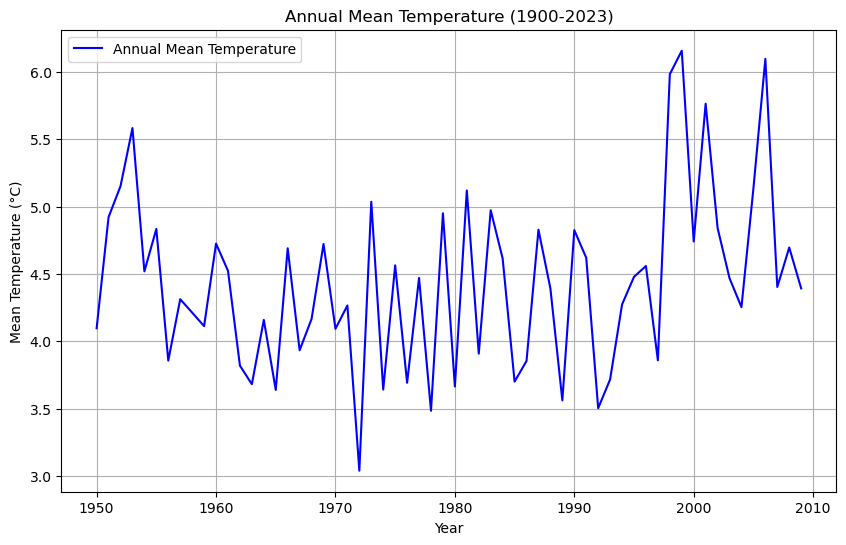

In [7]:
ecws_data = pd.read_csv('AHCCD_CONFINED.csv')

ecws_data['Year'] = pd.to_numeric(ecws_data['Year'], errors='coerce')#making sure yeaar is numeric and removing nans
ecws_data = ecws_data.dropna(subset=['Year'])

mean_temp_data = ecws_data[ecws_data['Value Type'] == 'Mean Temperature']#filter for mean temp

start_year = 1950
end_year = 2009
mean_temp_data = mean_temp_data[(mean_temp_data['Year'] >= start_year) & (mean_temp_data['Year'] <= end_year)]

yearly_avg = mean_temp_data[['Year', 'Annual']].groupby('Year').mean().reset_index() #extract year and annual columns

plt.figure(figsize=(10, 6))
plt.plot(yearly_avg['Year'], yearly_avg['Annual'], linestyle='-', color='blue', label='Annual Mean Temperature')
plt.title('Annual Mean Temperature (1900-2023)')
plt.xlabel('Year')
plt.ylabel('Mean Temperature (°C)')
plt.grid()
plt.legend()
plt.show()


### Scaled Comparison of Station vs Interpolated Data

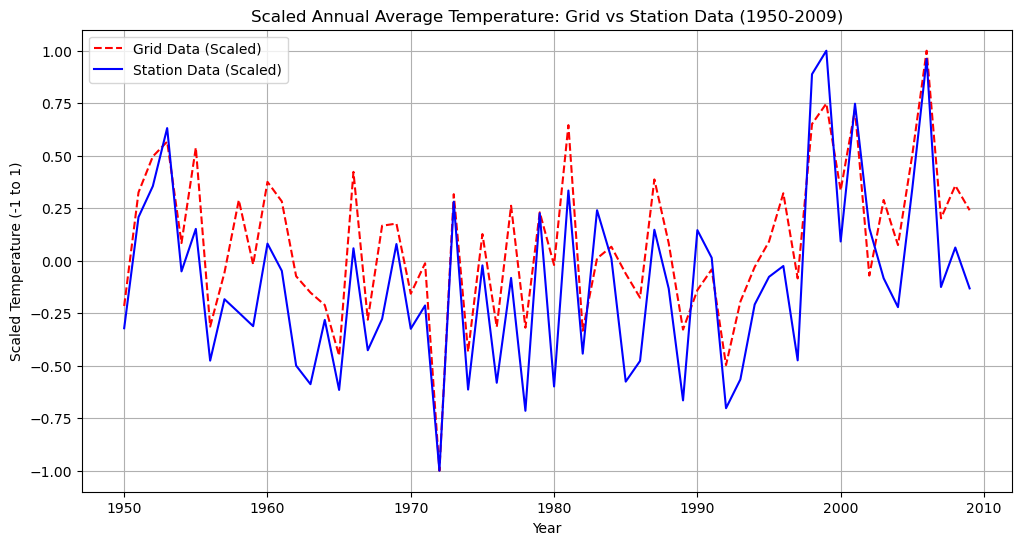

In [55]:
import matplotlib.pyplot as plt
import numpy as np

def scale_data(data): #scaling to normalise data
    return 2 * (data - np.min(data)) / (np.max(data) - np.min(data)) - 1

grid_years = average_temp_df['year'] #grid data
grid_temps = average_temp_df['Average Temperature']

station_years = yearly_avg['Year'] #station data
station_temps = yearly_avg['Annual']

common_years = set(grid_years).intersection(set(station_years)) #align years for comparison
grid_aligned = average_temp_df[average_temp_df['year'].isin(common_years)].sort_values('year')
station_aligned = yearly_avg[yearly_avg['Year'].isin(common_years)].sort_values('Year')

grid_scaled = scale_data(grid_aligned['Average Temperature']) #scale both datasets
station_scaled = scale_data(station_aligned['Annual'])

plt.figure(figsize=(12, 6))
plt.plot(grid_aligned['year'], grid_scaled, label='Grid Data (Scaled)', color='r', linestyle='--')
plt.plot(station_aligned['Year'], station_scaled, label='Station Data (Scaled)', color='b', linestyle='-')
plt.title('Scaled Annual Average Temperature: Grid vs Station Data (1950-2009)')
plt.xlabel('Year')
plt.ylabel('Scaled Temperature (-1 to 1)')
plt.legend()
plt.grid()
plt.show()

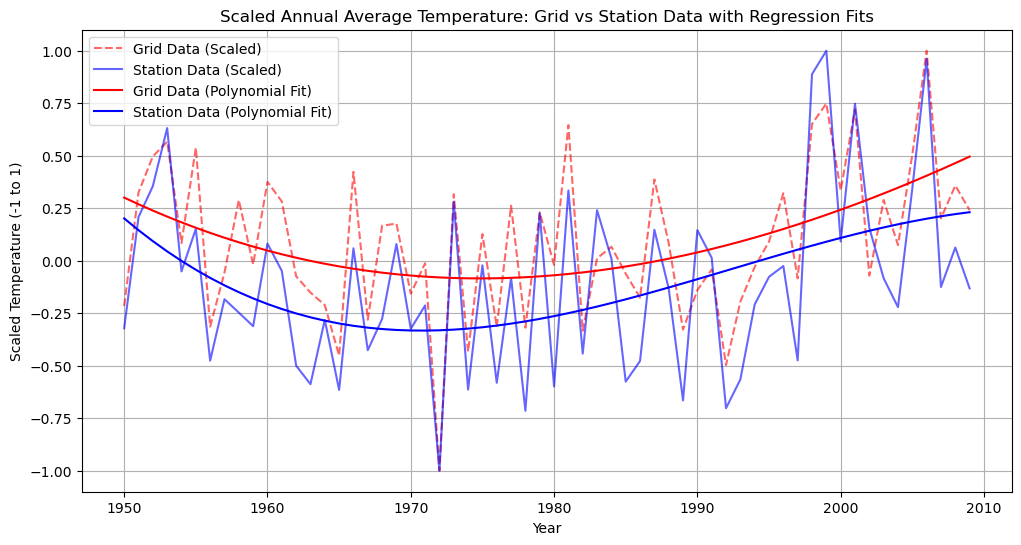

Grid Data Polynomial Coefficients: [-2.14606587e-06  1.32847217e-02 -2.73614704e+01  1.87528236e+04]
Station Data Polynomial Coefficients: [-1.44954834e-05  8.66407164e-02 -1.72599294e+02  1.14599699e+05]


In [73]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

def scale_data(data):
    return 2 * (data - np.min(data)) / (np.max(data) - np.min(data)) - 1

def fit_polynomial(x, y, degree=1): #polynomial fit
    coeffs = np.polyfit(x, y, degree)
    poly = np.poly1d(coeffs)
    return poly, coeffs

common_years = set(grid_years).intersection(set(station_years)) #aligning years for comparison
grid_aligned = average_temp_df[average_temp_df['year'].isin(common_years)].sort_values('year')
station_aligned = yearly_avg[yearly_avg['Year'].isin(common_years)].sort_values('Year')

grid_scaled = scale_data(grid_aligned['Average Temperature']) #scaling datasets
station_scaled = scale_data(station_aligned['Annual'])

years = grid_aligned['year'].values  #align years

poly_grid, coeffs_grid = fit_polynomial(years, grid_scaled, degree=3) #polynomial fit
poly_station, coeffs_station = fit_polynomial(years, station_scaled, degree=3)

plt.figure(figsize=(12, 6))

plt.plot(years, grid_scaled, label='Grid Data (Scaled)', color='r', linestyle='--', alpha=0.6) #time series data
plt.plot(years, station_scaled, label='Station Data (Scaled)', color='b', linestyle='-', alpha=0.6)

plt.plot(years, poly_grid(years), label='Grid Data (Polynomial Fit)', color='r', linestyle='-') #polynomial fit
plt.plot(years, poly_station(years), label='Station Data (Polynomial Fit)', color='b', linestyle='-')

plt.title('Scaled Annual Average Temperature: Grid vs Station Data with Regression Fits')
plt.xlabel('Year')
plt.ylabel('Scaled Temperature (-1 to 1)')
plt.legend()
plt.grid()
plt.show()

print(f"Grid Data Polynomial Coefficients: {coeffs_grid}")
print(f"Station Data Polynomial Coefficients: {coeffs_station}")
